# Assignment 3

## Problem 1 [20 Points]

Consider a Bayesian model with parameters $\theta$ for which you want to maximize its marginal log-likelihood $\log p(\mathcal{D})$ given some observed data $\mathcal{D}$. As this objective is generally intractable, assume a variational approximation to
the posterior by introducing an auxiliary distribution $q(\theta\lvert\mathcal{D})$.

(1) Please derive the following inequality
:
$\log p(\mathcal{D}) \geq \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log p(\mathcal{D}\lvert \theta) + \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log p(\theta) - \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log q(\theta\lvert\mathcal{D}) $


(2) Show that the above inequality becomes an equality when the KL divergence between the true posterior and your variational posterior becomes 0, i.e.

$$\mathbb{KL}[q(\theta\lvert\mathcal{D})||p(\theta\lvert \mathcal{D})] = 0$$

(3) One way to design a more flexible variational approximation beyond the mean-field familty is by considering an invertible transformation $f_{\phi}: \mathcal{Z} \to \mathcal{\Theta}$, where $\phi$ denotes the parameters of the invertible transformation.Using the change of variables formula, we can obtain a variational approximation $q_{\phi}(\theta | \mathcal{D})$ that is easy to sample from and easy to evaluate as

\begin{align}
    \theta &= f(z), \quad \text{with}\; z \sim p_z(z), \\
    q_{\phi} (\theta | \mathcal{D}) &= p_z(f_{\phi}^{-1}(\theta)) | \mathrm{det} \nabla_\theta (f_{\phi}^{-1} (\theta))|.
\end{align}

Derive a tractable optimization objective for identifying the optimal parameters $\phi$ via gradient-based optimization assuming that $p_z = \mathcal{N}(0, I)$.

## Answer

***Questions:***

**What is variational inference?**

Variational inference is a method used in Bayesian statistics and machine learning for approximating complex probability distributions. In Bayesian statistics, we are interested in finding the posterior distribution of model parameters given the observed data. However, in many cases, the posterior distribution cannot be computed analytically and must be approximated numerically. Variational inference is one such numerical approximation method.

The basic idea of variational inference is to approximate the true posterior distribution with a simpler, tractable distribution that is easy to work with. This simpler distribution is called the variational distribution, and it is chosen from a family of distributions that are easy to work with, such as Gaussian or exponential distributions. The goal is to find the variational distribution that is the closest to the true posterior distribution.

The closeness between the true posterior distribution and the variational distribution is measured using a divergence measure, typically the Kullback-Leibler (KL) divergence. The objective of variational inference is to minimize the KL divergence between the true posterior distribution and the variational distribution. This is done by solving an optimization problem, where the parameters of the variational distribution are adjusted iteratively until the KL divergence is minimized.

**Are all variational inference mean-field?**

No, not all variational inference methods are mean-field approximations. While mean-field variational inference is a commonly used approach, there are other methods that do not make the mean-field assumption.

Mean-field variational inference assumes that the variational distribution can be factorized into independent components, so that the joint distribution can be written as a product of simpler distributions. This assumption greatly simplifies the optimization problem, but it can also lead to biased or suboptimal solutions when the true posterior distribution is not well-approximated by a factorized distribution.

**Understand relation between Bayes' theorem and this, but how to prove (1)?**

## Problem 2 [40 Points]

Recall HW2 Question 2, where you derived the conditional distribution of a Bayesian regression model with a likelihood $p(y\lvert x, \alpha, \beta, \gamma)$ corresponding to a linear observation model is $y = \alpha x + \beta + \epsilon$. Noting that $\gamma$ represents the noise level in the observed data, i.e. it corresponds to the precision of the data likelihood. In this case, the likelihood can be further expressed as:

$p(y\lvert x, \alpha, \beta, \gamma) = (\sqrt{\frac{\gamma}{2\pi}})^n\exp(-\frac{\gamma(\sum_{i=1}^n\|y_i - x_i\alpha - \beta\|^2_2)}{2})$

while the conditional posteriors are:

$p(\alpha\lvert x, y, \beta, \gamma) = \mathcal{N}(\mu_1,\frac{1}{\lambda_1})$, where $\mu_1 = \frac{\gamma \sum_{i=1}^{n}x_i(y_i-\beta)}{1+\gamma \sum_{i=1}^{n}x_i^2}$ and $\lambda_1 = 1+\gamma \sum_{i=1}^{n}x_i^2$

$p(\beta\lvert x, y, \alpha, \gamma) = \mathcal{N}(\mu_2,\frac{1}{\lambda_2})$ where $\mu_2 = \frac{\gamma \sum_{i=1}^{n}(y_i-x_i\alpha)}{n\gamma+1}$ and $\lambda_2 = n\gamma+1$

$p(\gamma\lvert x, y, \alpha, \beta) =  \text{Gam}(a,b)$ where $a=\frac{n}{2}+2$ and $b = \frac{1}{2}[2+\sum_{i=1}^{n}(y_i-x_i\alpha-\beta)^2]$

Generate your training data by considering true parameters $\alpha, \beta, \gamma = 1.5, -3, 1$. Considering a uniform distribution, randomly sample $x$ in $[0, 3]$ using $N = 200$

(1) Implement the Gibbs sampling algorithms using the above conditional posteriors to generate $5,000$ samples from the target posterior distribution $p(\alpha,\beta,\gamma\lvert x, y)$. Discard the first 2,000 as a burn-in phase and plot a histogram generated from your samples. Also, please draw some samples of linear lines using $50$ samples you got.

(2) Gibbs sampling depends on deriving an analytical expression of the corresponding conditional posterior distributions. However, this cannot be done in many applications. Assume that you only have access to the unnormalized posterior, using the likelihood listed above and prior distributions: $p(\alpha) = \mathcal{N}(0, 1)$, $p(\beta) = \mathcal{N}(0, 1)$ and $p(\gamma) = \textrm{Gam(2, 1)}$. Implement the Metropolis algorithm to sample $5,000$ samples from the target posterior distribution $p(\alpha,\beta,\gamma\lvert x, y)$.  Discard the first 2,000 as a burn-in phase and plot a histogram generated from your samples. Please compare these histograms with the plots from Gibbs sampling. Also, please draw some samples of linear lines using $50$ samples you got.

In [21]:
# Setup

import jax.numpy as np
from jax import random, vmap, jit
from jax.lax import scan, cond
from functools import partial
from jax.experimental import host_callback
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

key = random.PRNGKey(42)

In [28]:
# Define conditional posteriors
def alpha_func(x, y, beta, gamma):
  mu_1 = gamma * np.sum(x * y-beta) / (1 + gamma * np.sum(x**2))
  lambda_1 = 1 + gamma * np.sum(x**2)
  return np.sqrt(1/lambda_1) * random.normal(key) + mu_1

def beta_func(x, y, alpha, gamma):
  n = len(x)
  mu_2 = gamma * np.sum(y * x-alpha) / (n * gamma + 1)
  lambda_2 = n * gamma + 1
  return np.sqrt(1/lambda_2) * random.normal(key) + mu_2

def gamma_func(x, y, alpha, beta):
  n = len(x)
  a = n/2 + 2
  b = (1/2)*(2+np.sum((y - x*alpha - beta)**2))
  return random.gamma(key, ????? )

# Define true parameters
alpha, beta, gamma = 1.5, -3, 1

In [29]:
# Generate training data D = (x, y) where, N = 200
x = random.uniform(key, (200,), minval = 0.0, maxval = 3.0)
epsilon = random.normal(key, (200,)) * gamma
y = alpha*x + beta + epsilon

### Subproblem 1

In [30]:
samples_alpha = np.zeros(5000)
samples_beta = np.zeros(5000)
samples_gamma = np.zeros(5000)

# Initial values
samples_alpha = samples_alpha.at[0].set(0.1)
samples_beta = samples_beta.at[0].set(0.1)
samples_gamma = samples_gamma.at[0].set(0.1)

# Gibbs sampling algorithm
for i in range(4999):
  samples_alpha = samples_alpha.at[i+1].set(alpha_func(x, y, samples_beta[i], samples_gamma[i]))
  samples_beta = samples_beta.at[i+1].set(beta_func(x, y, samples_alpha[i+1], samples_gamma[i]))
  samples_gamma = samples_gamma.at[i+1].set(gamma_func(x, y, samples_alpha[i+1], samples_beta[i+1]))

# Eliminate burn-in phase
samples_alpha = samples_alpha[2000:]
samples_beta = samples_beta[2000:]
samples_gamma = samples_gamma[2000:]

TypeError: ignored

NameError: ignored

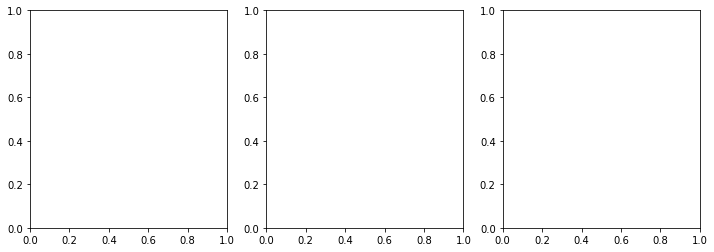

In [15]:
# PLOT HISTOGRAM
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(alpha_samples, bins=30, density=True)
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Density')
ax[1].hist(beta_samples, bins=30, density=True)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Density')
ax[2].hist(gamma_samples, bins=30, density=True)
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Density')
plt.tight_layout()
plt.show()


# Randomly select 50 samples & plot



### Subproblem 2

Question: Shape & scale vs shape & rate for gamma. And how to use gamma function.

# Problem 3 [20 Points]

(1) The Fisher Information Matrix is defined as:
$F = \mathbb{E}_{p(x\lvert \theta)}[\nabla_{\theta}\log p(x|\theta)\nabla_{\theta}\log p(x|\theta)^T]$
Prove that negative expected Hessian of log-likelihood is equal to the Fisher Information Matrix $F$.

(2) Prove that Fisher Information Matrix F is the Hessian of KL-divergence between two distributions $p(x\lvert \theta)$ and $p(x\lvert \theta')$ with respect to $\theta'$ evaluated at $\theta' = \theta$.

## Answer

Questions:
- Why is the Fisher Information Matrix written like that?

# Problem 4 [20 Points]

Consider the evolution of the Lotka-Volterra model (also called Predator-Prey equations) that describes the dynamics of two species $u$ and $v$ in a closed system. The dynamics of the system is governed by the following equations:

\begin{align}
    \frac{du}{dt} &= \alpha u - \beta u v, \\
    \frac{dv}{dt} &= \delta u v - \gamma v,
\end{align}

where, $u$ is the number of prey (for example, rabbits), $v$ is the number of predators (for example, foxes). The parameters $\alpha, \beta, \gamma, \delta$ are positive constants that describe the interaction between the two species. 
- $\alpha$ is the growth rate of the prey population when there are no predators.
- $\beta$ is the rate at which predators kill prey.
- $\gamma$ is the rate at which predators die.
- $\delta$ is the rate at which predators reproduce.

(1) Numerically integrate this system for choice of initial conditions $u(0) = 10, v(0) = 5$ and $\alpha = 1, \beta = 0.1, \gamma = 1.5, \delta = 0.75$. Plot the trajectories of $u$ and $v$ over a time of 15 days using 100 timesteps.

(2) Perturb the numerically integrated data with Gaussian noise having 10% standard deviation of the clean data. Utilizing this data, infer the underlying parameters for the model utilizing [MALA](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm). Plot the posterior distributions for the inferred parameters. Consider the following priors for your model:
\begin{align}
    p(\alpha) &= \mathrm{Gamma}(9, 0.1), \\
    p(\beta) &= \mathrm{Gamma}(2, 0.05), \\
    p(\gamma) &= \mathrm{Gamma}(2, 1), \\
    p(\delta) &= \mathrm{Gamma}(1, 1), \\
    p(\sigma_n) &= \mathrm{InvGamma}(1, 2)
\end{align}

## Answer

In [ ]:
# Heavily inspired by # metropolis_SEIC

In [ ]:
# Very similar to Metropolis algorithm implemented

In [ ]:
# your code here